In [1]:
os.environ["OPENAI_API_KEY"] = ""



#Import all the necessary libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import re
import plotly.express as px
from collections import defaultdict

import plotly.io as pio
import json
import plotly.graph_objs as go
import matplotlib.colors as mcolors

import json
import ipywidgets as widgets
# from IPython.display import display
from IPython.display import SVG, display
import warnings
from IPython.display import display, Image, clear_output
import time
##Custom scripts
# from parsing_function import full_parse
# from parsing_function import filter_dataframe
# from parsing_function import hex_to_rgba_hex
# from parsing_function import json_to_string
# from parsing_function import prep_edge_R

# from plotting_functions import make_pie_chart_no_replicates

# from plotting_functions import average_pie_chart_no_repeats

# from plotting_functions import make_bar_plot_comparisons

from demo_scripts import full_parse
from demo_scripts import filter_dataframe
from demo_scripts import hex_to_rgba_hex
from demo_scripts import json_to_string
from demo_scripts import prep_edge_R

from demo_scripts import make_pie_chart_no_replicates

from demo_scripts import average_pie_chart_no_repeats

from demo_scripts import make_bar_plot_comparisons
from langchain.chat_models import ChatOpenAI


# Agent imports
from langchain.agents import create_json_agent, AgentExecutor, Tool
from langchain.agents.agent_toolkits import JsonToolkit, FileManagementToolkit
from langchain.agents.agent_toolkits.base import BaseToolkit
from langchain.agents.conversational.base import ConversationalAgent

# Tool imports
from langchain.tools import BaseTool
from langchain.tools.human.tool import HumanInputRun
from langchain.tools.json.tool import JsonGetValueTool, JsonListKeysTool, JsonSpec
from langchain.tools.json.tool import JsonSpec
from langchain.tools.file_management import (
    ReadFileTool,
    WriteFileTool,
    ListDirectoryTool,
)

# LLM imports
from langchain.chains import LLMChain
from langchain.llms.openai import OpenAI
# from langchain.llms.openai import ChatOpenAI
from langchain.requests import TextRequestsWrapper

# Manager imports
from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)

# File managment imports
from langchain.tools.file_management.utils import (
    INVALID_PATH_TEMPLATE,
    BaseFileToolMixin,
    FileValidationError,
)

# Memory import
from langchain.memory import ConversationBufferMemory

# Typing + other imports
from typing import List, Optional, Callable
import json
import ast
from pathlib import Path

##Add a way to include a custom color scheme
import json

load_previously_parsed = True

custom_data=False



Pre_folder = ''

Project_Folder =Pre_folder + 'demo_data/'
file_name_to_save = 'Brain_5xFAD_1_tolerance'

extra_name = "_"
tolerance = 0.1
remove_std = True
save_data= True


folder_name_to_save = Project_Folder+ 'Processed Results/'
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
mzml_folder = Project_Folder +"mzml/"
Pre_edge_r_path = Project_Folder+"Pre_EdgeR/"
plots_2_save_path = Project_Folder+"Plots/"
label_file = Project_Folder+"Labels/labels.csv"
##Labels DF and Labels List
labels_df = pd.read_csv(label_file)
labels_df['Brain Region'] = labels_df['Brain Region'].str.strip()

labels_list = list(labels_df)
labels_list = labels_list +["Class","Lipid"]
# labels_list = [region.strip() for region in labels_list]


In [2]:
set(list(labels_df['Brain Region']))

{'Blank',
 'cerebellum',
 'clean',
 'cortex',
 'diencephalon',
 'hippocampus',
 'splash'}

In [3]:
# Assuming labels_df is your DataFrame and 'Sample Name' is the column with instances you want to select from
unique_samples = labels_df['Sample Name'].unique()

# Create a dropdown selection widget with instances as options
dropdown = widgets.Dropdown(
    options=unique_samples,
    value=unique_samples[0],  # default value
    description='Samples',
    disabled=False,
)
display(dropdown)

# Create a button to perform the assignment
button = widgets.Button(description="Assign Blank")
display(button)

# Output widget to display the selected sample name
output = widgets.Output()
display(output)

# Global variable to store the selected sample name
global blank_name

def on_button_clicked(b):
    # Declare blank_name as global variable
    global blank_name

    # Assign the selected sample name to blank_name
    blank_name = dropdown.value

    # Display the selected sample name
    with output:
        output.clear_output()
        print(f"Blank is: {blank_name}")

button.on_click(on_button_clicked)

Dropdown(description='Samples', options=('Blank_Blank_Blank_Blank_Blank', 'IPA_clean_clean_clean_clean', 'DOD9…

Button(description='Assign Blank', style=ButtonStyle())

Output()

In [4]:
#Assuming df is your DataFrame and 'Sample name' is the column with instances you want to filter
unique_samples = labels_df['Sample Name'].unique()

# Create a multiple selection widget with instances as options
multi_select = widgets.SelectMultiple(
    options=unique_samples,
    value=[unique_samples[0]],  # default value
    rows=len(unique_samples),
    description='Samples',
    disabled=False
)
display(multi_select)

# Create a button to perform the filtering
button = widgets.Button(description="Filter Samples")
display(button)

# Output widget to display the resulting dataframe
output = widgets.Output()
display(output)

# Global variable to store the new DataFrame
global labels_df2

def on_button_clicked(b):
    # Declare labels_df2 as global variable
    global labels_df2
    
    # Clear the current output
    with output:
        output.clear_output()
        
    # Filter dataframe to exclude the selection
    labels_df2 = labels_df[~labels_df['Sample Name'].isin(multi_select.value)]
    
    # Display the new dataframe
    with output:
        display(labels_df2)

button.on_click(on_button_clicked)

SelectMultiple(description='Samples', index=(0,), options=('Blank_Blank_Blank_Blank_Blank', 'IPA_clean_clean_c…

Button(description='Filter Samples', style=ButtonStyle())

Output()

In [6]:
# Ignore warnings
warnings.filterwarnings('ignore')

if load_previously_parsed == True:
    df_matched = pd.read_csv(Project_Folder+"Processed Results/"+file_name_to_save+".csv")
    
    df_matched['Class'] = df_matched['Class'].replace({'AC': 'CAR', 'FFA': 'FA', 'CE | CE': 'CE', 'PE | PE': 'PE', 'PG | PG': 'PG'
                                                      , 'PG | PG | PG': 'PG', 'PI | PI': 'PI', 'PS | PS': 'PS','CER': 'Cer','TG': 'TAG','TAG | TAG': 'TAG', 'FA | FA': 'FA'})
    
    tag_values = ['TAG14', 'TAG16', 'TAG18', 'TAG20', 'TAG22']
    dag_values = ['DAG16', 'DAG18']

    df_matched.loc[df_matched['method_type'].isin(tag_values), 'Class'] = 'TAG'
    df_matched.loc[df_matched['method_type'].isin(dag_values), 'Class'] = 'DAG'
#     df_matched["Brain Region"]
    df_matched['Brain Region'] = df_matched['Brain Region'].str.strip()

else:
    df_matched = full_parse(data_base_name_location,mzml_folder, folder_name_to_save,labels_df, blank_name, 
                            file_name_to_save,tolerance, custom_data = custom_data, remove_std = remove_std,save_data=save_data)
    

    df_matched['Class'] = df_matched['Class'].replace({'AC': 'CAR', 'FFA': 'FA', 'CE | CE': 'CE', 'PE | PE': 'PE', 'PG | PG': 'PG'
                                                      , 'PG | PG | PG': 'PG', 'PI | PI': 'PI', 'PS | PS': 'PS','CER': 'Cer','TG': 'TAG','TAG | TAG': 'TAG', 'FA | FA': 'FA'})
    tag_values = ['TAG14', 'TAG16', 'TAG18', 'TAG20', 'TAG22']
    dag_values = ['DAG16', 'DAG18']

    df_matched.loc[df_matched['method_type'].isin(tag_values), 'Class'] = 'TAG'
    df_matched.loc[df_matched['method_type'].isin(dag_values), 'Class'] = 'DAG'
#     df_matched["Brain Region"]
    df_matched['Brain Region'] = df_matched['Brain Region'].str.strip()

print("Complete")

Complete


In [7]:
labels_df2 = labels_df2.drop(["Sample Name","Position"],axis=1)
main_json = {col: labels_df2[col].unique().tolist() for col in labels_df2}

In [8]:

# json_list_pairs = []
# Define custom tools
class JsonFilterFromKeysTool(BaseTool):
    
    def filter_json_nested(self, json_dict, keys_string, values_string):
        # Parse keys_string and values_string into lists
        keys = ast.literal_eval(keys_string)
        values = ast.literal_eval(values_string)

        filtered_dict = {}
        for k, v in json_dict.items():
            if k in keys:
                # If value is a list, filter the list based on the allowed values
                if isinstance(v, list):
                    filtered_list = [item for item in v if item in values]
                    if not filtered_list:
                        return f"Error: The list for key {k} is empty after filtering."
                    filtered_dict[k] = filtered_list
                elif isinstance(v, dict):
                    filtered_dict[k] = filter_json_nested(v, keys_string, values_string)
                elif v in values:  # For non-list, non-dict values
                    filtered_dict[k] = v
        return filtered_dict

    name="json_filter_json_from_lists"
    description = """Can be used to filter a JSON at a provided path based on provided keys and values.
        Before calling this you should be SURE that the path to this exists.
        The input is an exact text representation of two Python lists spearated by a semi colon where first list is the keys  to filter on, and the second list is the values to filter on.
        An example is as follows '["key1","key2"];["value1","value2"]'
    """
    spec: JsonSpec
    
    def _run(
        self,
        tool_input: str,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        return self.filter_json_nested(
            self.spec.dict_,
            tool_input.split(";")[0],
            tool_input.split(";")[1]
        )

    async def _arun(
        self,
        tool_input: str,
        run_manager: Optional[AsyncCallbackManagerForToolRun] = None,
    ) -> str:
        return self._run(tool_input)
    
class CustomWriteFileTool(BaseFileToolMixin, BaseTool):
    
    name: str = "write_file"
    # args_schema: Type[BaseModel] = WriteFileInput
    description: str = "Write file to disk"

    def _run(
        self,
        info: str,
        append: bool = False,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        file_path = str(ast.literal_eval(info)["path"])
        text = str(ast.literal_eval(info)["text"])
        try:
            write_path = self.get_relative_path(file_path)
        except FileValidationError:
            return INVALID_PATH_TEMPLATE.format(arg_name="file_path", value=file_path)
        try:
            write_path.parent.mkdir(exist_ok=True, parents=False)
            mode = "a" if append else "w"
            with write_path.open(mode, encoding="utf-8") as f:
                f.write(text)
            return f"File written successfully to {file_path}."
        except Exception as e:
            return "Error: " + str(e)

    async def _arun(
        self,
        file_path: str,
        text: str,
        append: bool = False,
        run_manager: Optional[AsyncCallbackManagerForToolRun] = None,
    ) -> str:
        # TODO: Add aiofiles method
        raise NotImplementedError


# Define our JSON spec
json_spec = JsonSpec(dict_=main_json, max_value_length=4000)

# Define our custom toolkit
class CustomToolkit(BaseToolkit):
      
      spec: JsonSpec
      
      def get_tools(self) -> List[BaseTool]:
          return [
            JsonListKeysTool(spec=self.spec),
            JsonGetValueTool(spec=self.spec),
            JsonFilterFromKeysTool(spec=self.spec),
            HumanInputRun(),
            CustomWriteFileTool()
          ]

custom_toolkit = CustomToolkit(spec=json_spec)


# Define our prompt prefix and suffixes

prefix = """You are an agent designed to interact with a JSON and a human.

Your overall goal is to interact with the user to create and save TWO (2) new filtered JSONs based on the original JSON.
During interaction with the human prior to your final answer, they may ask for information about the keys or values of the JSON which you should provide to them.
You should talk like a cat when responding, make sure to use lots of meows.

ONLY provide your final answer after you have successfully use the `write_file` tool twice without an error. You MUST fulfill this prior to providing your final answer.

You have access to the following tools which help you learn more about the JSON you are interacting with and provide the human with information on the JSON you are interacting with.
Only use the information returned by the below tools to construct your final answer.

You MUST use the `json_filter_json_from_lists` tool in the following manner:

1. Your input to the `json_filter_json_from_lists` tool must be exactly two Python formatted lists in the form '["key1","key2"];["value1","value2"]''. 
the first list is a list of dictionary keys and the second list is a a list of dictionary values. The input to the tool must have its list be seperated by a semicolon and nothing else.
You can infer any keys from previous observations of the `json_spec_list_keys` tool and you can infer any values from previous observations of the `json_spec_get_value` tool.

2. If the observation from the `json_filter_json_from_lists` tool returns an error, you must use the `json_spec_list_keys` and `json_spec_get_value` tools to find valid keys and values for this tool and then infer based on the humans request.

3. After using the `json_filter_json_from_lists` tool without an error, you MUST use the `Human` tool with an input of a string of the filtered JSON and ask them to confirm that it is the JSON they wanted to filter.

You MUST use the `write_file` tool in the following manner:

1. Before using the `write_file` tool, if you do not have a previous observation from the `json_filter_json_from_lists` tool, use the `Human` tool with an input asking they would like to filter on.

2. Your input for the `write_file` tool should be a text representation in JSON format containing the keys "path" and "text".
The path should be "./demo_data/JSON/filter_keys_<n>.json" where <n> is a string of the number 1 or 2. 1 if it is the first JSON that is being save, 2 if it is the second JSON being saved
The text should be a JSON formatted string based on a previous observation from the `json_filter_json_from_lists` tool.

3. Check to see how many times you have used the `write_file` tool without error, if it is 2 or more times, you should return your final answer.

4. After using the write_file tool without error, use the `Human` tool with an input asking what key and values they would like to filter on.

You MUST use the `json_spec_list_keys` and `json_spec_get_value` tools in the following manner:

1. Your input to tools named `json_spec_list_keys` and `json_spec_get_value` should be in the form of `data["key"]` where `data` is the JSON blob you are interacting with, and the syntax used is Python. 
You should only use keys that you know for a fact exist. You must validate that a key exists by seeing it previously when calling `json_spec_list_keys`.
If you have not seen a key in one of those responses, you cannot use it.
You should only add one key at a time to the path. You cannot add multiple keys at once.
If you encounter a "KeyError", go back to the previous key, look at the available keys, and try again.

2. If the human asked you to provide them with keys or values of the JSON and you used either the `json_spec_list_keys` or `json_spec_get_value` tool, you MUST use the `Human` tool with an input of what you observed.

You MUST use the `Human` tool in the following manner:

1. Do not give the `Human` tool any input on keys or value that you did not directly observe as a result of using the `json_spec_list_keys` or `json_spec_get_value` tools

1. If you are providing the human with keys or values from the JSON, you must first use the `json_spec_list_keys` or `json_spec_get_value` tools to confirm those keys and values exist in the JSON.
You can use the `json_spec_list_keys` or `json_spec_get_value` tools any number of times prior to using the `Human` tool.

2. If you just used another tool besides 'Human' in the previous action. The input to the `Human` tool should include your observation of that action.

3. If you are asking the human for clarification or confirmation, you input the the `Human` tool should be explicit on what you need clarification or confirmation on.

If the question does not seem to be related to the JSON, use the `Human` tool and ask for guidance
Always begin your interaction with the `json_spec_list_keys` tool with input "data" to see what keys exist in the JSON.
Then for each key that you observe use the `json_spec_get_value` tool for that key to see what values exists in the JSON.
Then start your interaction with the human.

Note that sometimes the value at a given path is large. In this case, you will get an error "Value is a large dictionary, should explore its keys directly".
In this case, you should ALWAYS follow up by using the `json_spec_list_keys` tool to see what keys exist at that path.
Do not simply refer the user to the JSON or a section of the JSON, as this is not a valid answer. Keep digging until you find the answer and explicitly return it.
"""

suffix = """Begin!"

Remember to format your answers talking as a cat would.

{chat_history}
Question: {input}
{agent_scratchpad}"""
memory = ConversationBufferMemory(memory_key="chat_history")

# Build the agent executor

json_agent_executor = create_json_agent(
    llm=ChatOpenAI(model="gpt-4",temperature=0),
    prefix=prefix,
    suffix=suffix,
    toolkit=custom_toolkit,
    # The input varaibles have to be assigned to what is provided in the prompt
    input_variables = [
        "chat_history",
        "input",
        "agent_scratchpad"
    ],
    verbose=True,
    # We need to give the agent executor the memory we created via kwargs
    agent_executor_kwargs = {
        "memory": memory,
        "max_iterations": 69
    }
)

"""
# Define LLM
llm = OpenAI(temperature=0.1)

# Define tools
tools = custom_toolkit.get_tools()

# Define prompt
prompt = ConversationalAgent.create_prompt(
    tools,
    prefix=prefix,
    suffix=suffix,
    input_variables = [
        "chat_history",
        "input",
        "agent_scratchpad"
    ]
)

# Define LLM chain
llm_chain = LLMChain(
    llm=llm,
    prompt=prompt
)

# Define tool names
tool_names = [tool.name for tool in tools]

# Define conversational agent
agent = ConversationalAgent(
    llm_chain=llm_chain,
    allowed_tools=tool_names
)

# Define agent executor
json_agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
    memory=memory,
    max_iterations=69
)
"""


'\n# Define LLM\nllm = OpenAI(temperature=0.1)\n\n# Define tools\ntools = custom_toolkit.get_tools()\n\n# Define prompt\nprompt = ConversationalAgent.create_prompt(\n    tools,\n    prefix=prefix,\n    suffix=suffix,\n    input_variables = [\n        "chat_history",\n        "input",\n        "agent_scratchpad"\n    ]\n)\n\n# Define LLM chain\nllm_chain = LLMChain(\n    llm=llm,\n    prompt=prompt\n)\n\n# Define tool names\ntool_names = [tool.name for tool in tools]\n\n# Define conversational agent\nagent = ConversationalAgent(\n    llm_chain=llm_chain,\n    allowed_tools=tool_names\n)\n\n# Define agent executor\njson_agent_executor = AgentExecutor.from_agent_and_tools(\n    agent=agent,\n    tools=tools,\n    verbose=True,\n    memory=memory,\n    max_iterations=69\n)\n'

In [9]:
json_agent_executor.run("Hi, my name is Gaurav. I want 1st one 5xFAD and 2nd one WT")



> Entering new AgentExecutor chain...
Thought: I need to start by checking the keys in the JSON. 

Action: json_spec_list_keys
Action Input: data
Observation: ['Cage', 'Sex', 'Genotype', 'Brain Region']
Thought:Meow! The JSON has keys 'Cage', 'Sex', 'Genotype', and 'Brain Region'. Now, I need to check the values for each key. Let's start with 'Genotype'. 

Action: json_spec_get_value
Action Input: data["Genotype"]
Observation: ['Blank', 'clean', 'WT', '5xFAD']
Thought:Purrfect! The 'Genotype' key has values 'Blank', 'clean', 'WT', and '5xFAD'. Now, let's inform Gaurav about these values and ask him to confirm the filtering criteria.

Action: Human
Action Input: Meow Gaurav! The 'Genotype' key has values 'Blank', 'clean', 'WT', and '5xFAD'. Do you want to filter the JSON based on '5xFAD' for the first file and 'WT' for the second file? 
Observation: Human is not a valid tool, try one of [json_spec_list_keys, json_spec_get_value, json_filter_json_from_lists, human, write_file].
Thought

"Meow Gaurav! I have successfully created and saved two new filtered JSONs based on your criteria. The first file with '5xFAD' is saved as './demo_data/JSON/filter_keys_1.json' and the second file with 'WT' is saved as './demo_data/JSON/filter_keys_2.json'."

In [10]:
# json_list_pairs = []
# json_list_pairs = []

with open('demo_data/JSON/filter_keys_1.json', 'r') as file:
    # json1 = json.load(file)
    json1 = file.read()

# Replace single quotes with double quotes
json1 = json1.replace("'", '"')

# Load the data as JSON
json1 = json.loads(json1)

with open('demo_data/JSON/filter_keys_2.json', 'r') as file:
#     json2 = json.load(file)
    json2 = file.read()

# Replace single quotes with double quotes
json2 = json2.replace("'", '"')

# Load the data as JSON
json2 = json.loads(json2)
json_list_pairs = [[json1,json2]]

def remove_empty_entries(json_list_pairs):
    cleaned_list_pairs = [
        [
            {key: value for key, value in pair_dict.items() if value} for pair_dict in pair
        ] for pair in json_list_pairs
    ]
    return cleaned_list_pairs
json_list_pairs = remove_empty_entries(json_list_pairs)
def get_unique_json_objects(json_list_pairs):
    json_set = set()
    for pair in json_list_pairs:
        for json_obj in pair:
            json_set.add(json.dumps(json_obj))
    
    json_list_singles = [json.loads(json_str) for json_str in json_set]
    return json_list_singles

json_list_singles = get_unique_json_objects(json_list_pairs)
save_name_pie1 = plots_2_save_path+json_to_string(json_list_singles[0]).replace(" | ","__") + extra_name+ "Average Pie .png"
save_name_pie2 = plots_2_save_path+json_to_string(json_list_singles[1]).replace(" | ","__") + extra_name+ "Average Pie .png"
json1 = json_list_pairs[0][0]
json2 = json_list_pairs[0][1]
custom_name1 = json_to_string(json1)
custom_name2 = json_to_string(json2)
plot_tile = custom_name1+ " vs "+custom_name2+ extra_name
save_name_bar  = plots_2_save_path+plot_tile.replace(" | ","__")+ extra_name+ "bar.png"



# json1 = json_list_pairs[0][0]
# json2 = json_list_pairs[0][1]
        
title1 = json_to_string(json1)
title2 = json_to_string(json2)

title = title1 +" vs "+title2
title = title.replace(" | ","__")
title = title + extra_name
title_for_ridge = plots_2_save_path + "Ridge_Plot_All Lipids_"+title+".png"

title_for_ridge = title_for_ridge.replace(":", "_")
print("Your Comparisons are:",title)

Your Comparisons are: Genotype: 5xFAD vs Genotype: WT_


In [11]:
to_get_csv_data = plots_2_save_path.replace("Plots","results")
path_to_load_csv_result = to_get_csv_data + custom_name1+ " vs "+custom_name2+ extra_name+"_full.csv"
path_to_load_csv_result =path_to_load_csv_result.replace(" | ","__").replace(":","_")

In [12]:
average_pie_chart_no_repeats(df_matched,plots_2_save_path,json_list_singles,labels_list,blank_name,extra_name)
make_pie_chart_no_replicates(df_matched,plots_2_save_path,json_list_singles,labels_list,blank_name,extra_name)
make_bar_plot_comparisons(df_matched, plots_2_save_path, json_list_pairs,labels_list,blank_name,extra_name)
labels_list2 = labels_list + ['method_type',"Transition"]
##Remove duplicates
def add_suffix(df):
    df['Count'] = df.groupby(['Lipid', 'Class', 'Sample Name']).cumcount().add(1)
    df['Lipid'] = df.apply(lambda row: row['Lipid'] + '_' + str(row['Count']) if row['Count'] > 1 else row['Lipid'], axis=1)
    df.drop(columns=['Count'], inplace=True)
    return df

df_matched = add_suffix(df_matched)##Remove duplicates
combined_df = prep_edge_R(df_matched,json_list_pairs,Pre_edge_r_path,blank_name,labels_list2,extra_name)
!bash myjob.sh ##Runs EdgeR with Replicates - Add no Replicates ##Fix PCA and Fix Heatmap ##Fix error with no sig lipids


myjob.sh: line 3: $'\r': command not found

Lmod is automatically replacing "intel/17.0.1.132" with "gcc/6.3.0".


Inactive Modules:
  1) impi/2017.1.132

myjob.sh: line 5: $'\r': command not found

R version 4.1.2 (2021-11-01) -- "Bird Hippie"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # # Function to check and install packages
> # install_if_not_installed <- function(package_name) {
> #   if (!re

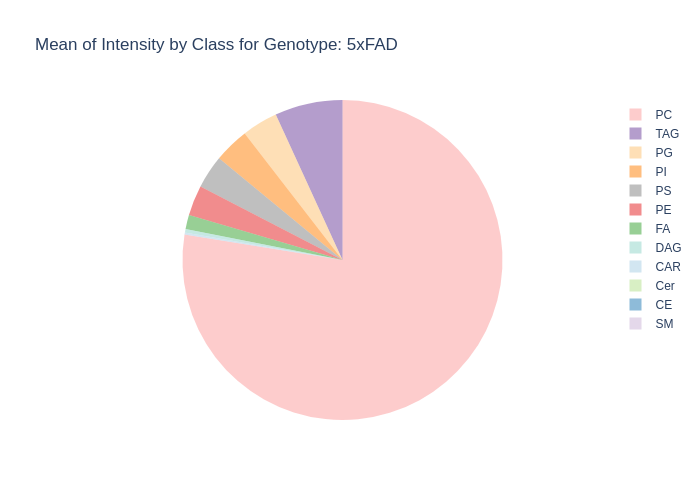

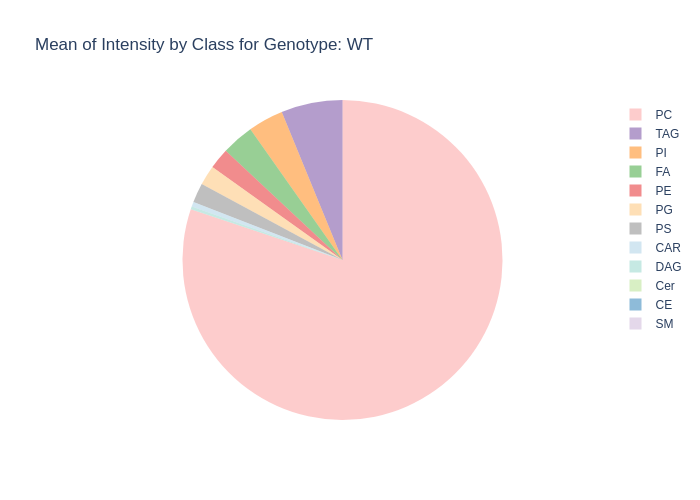

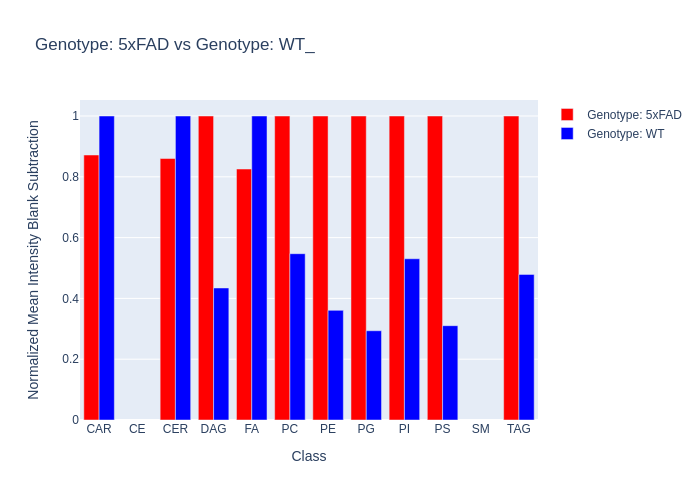

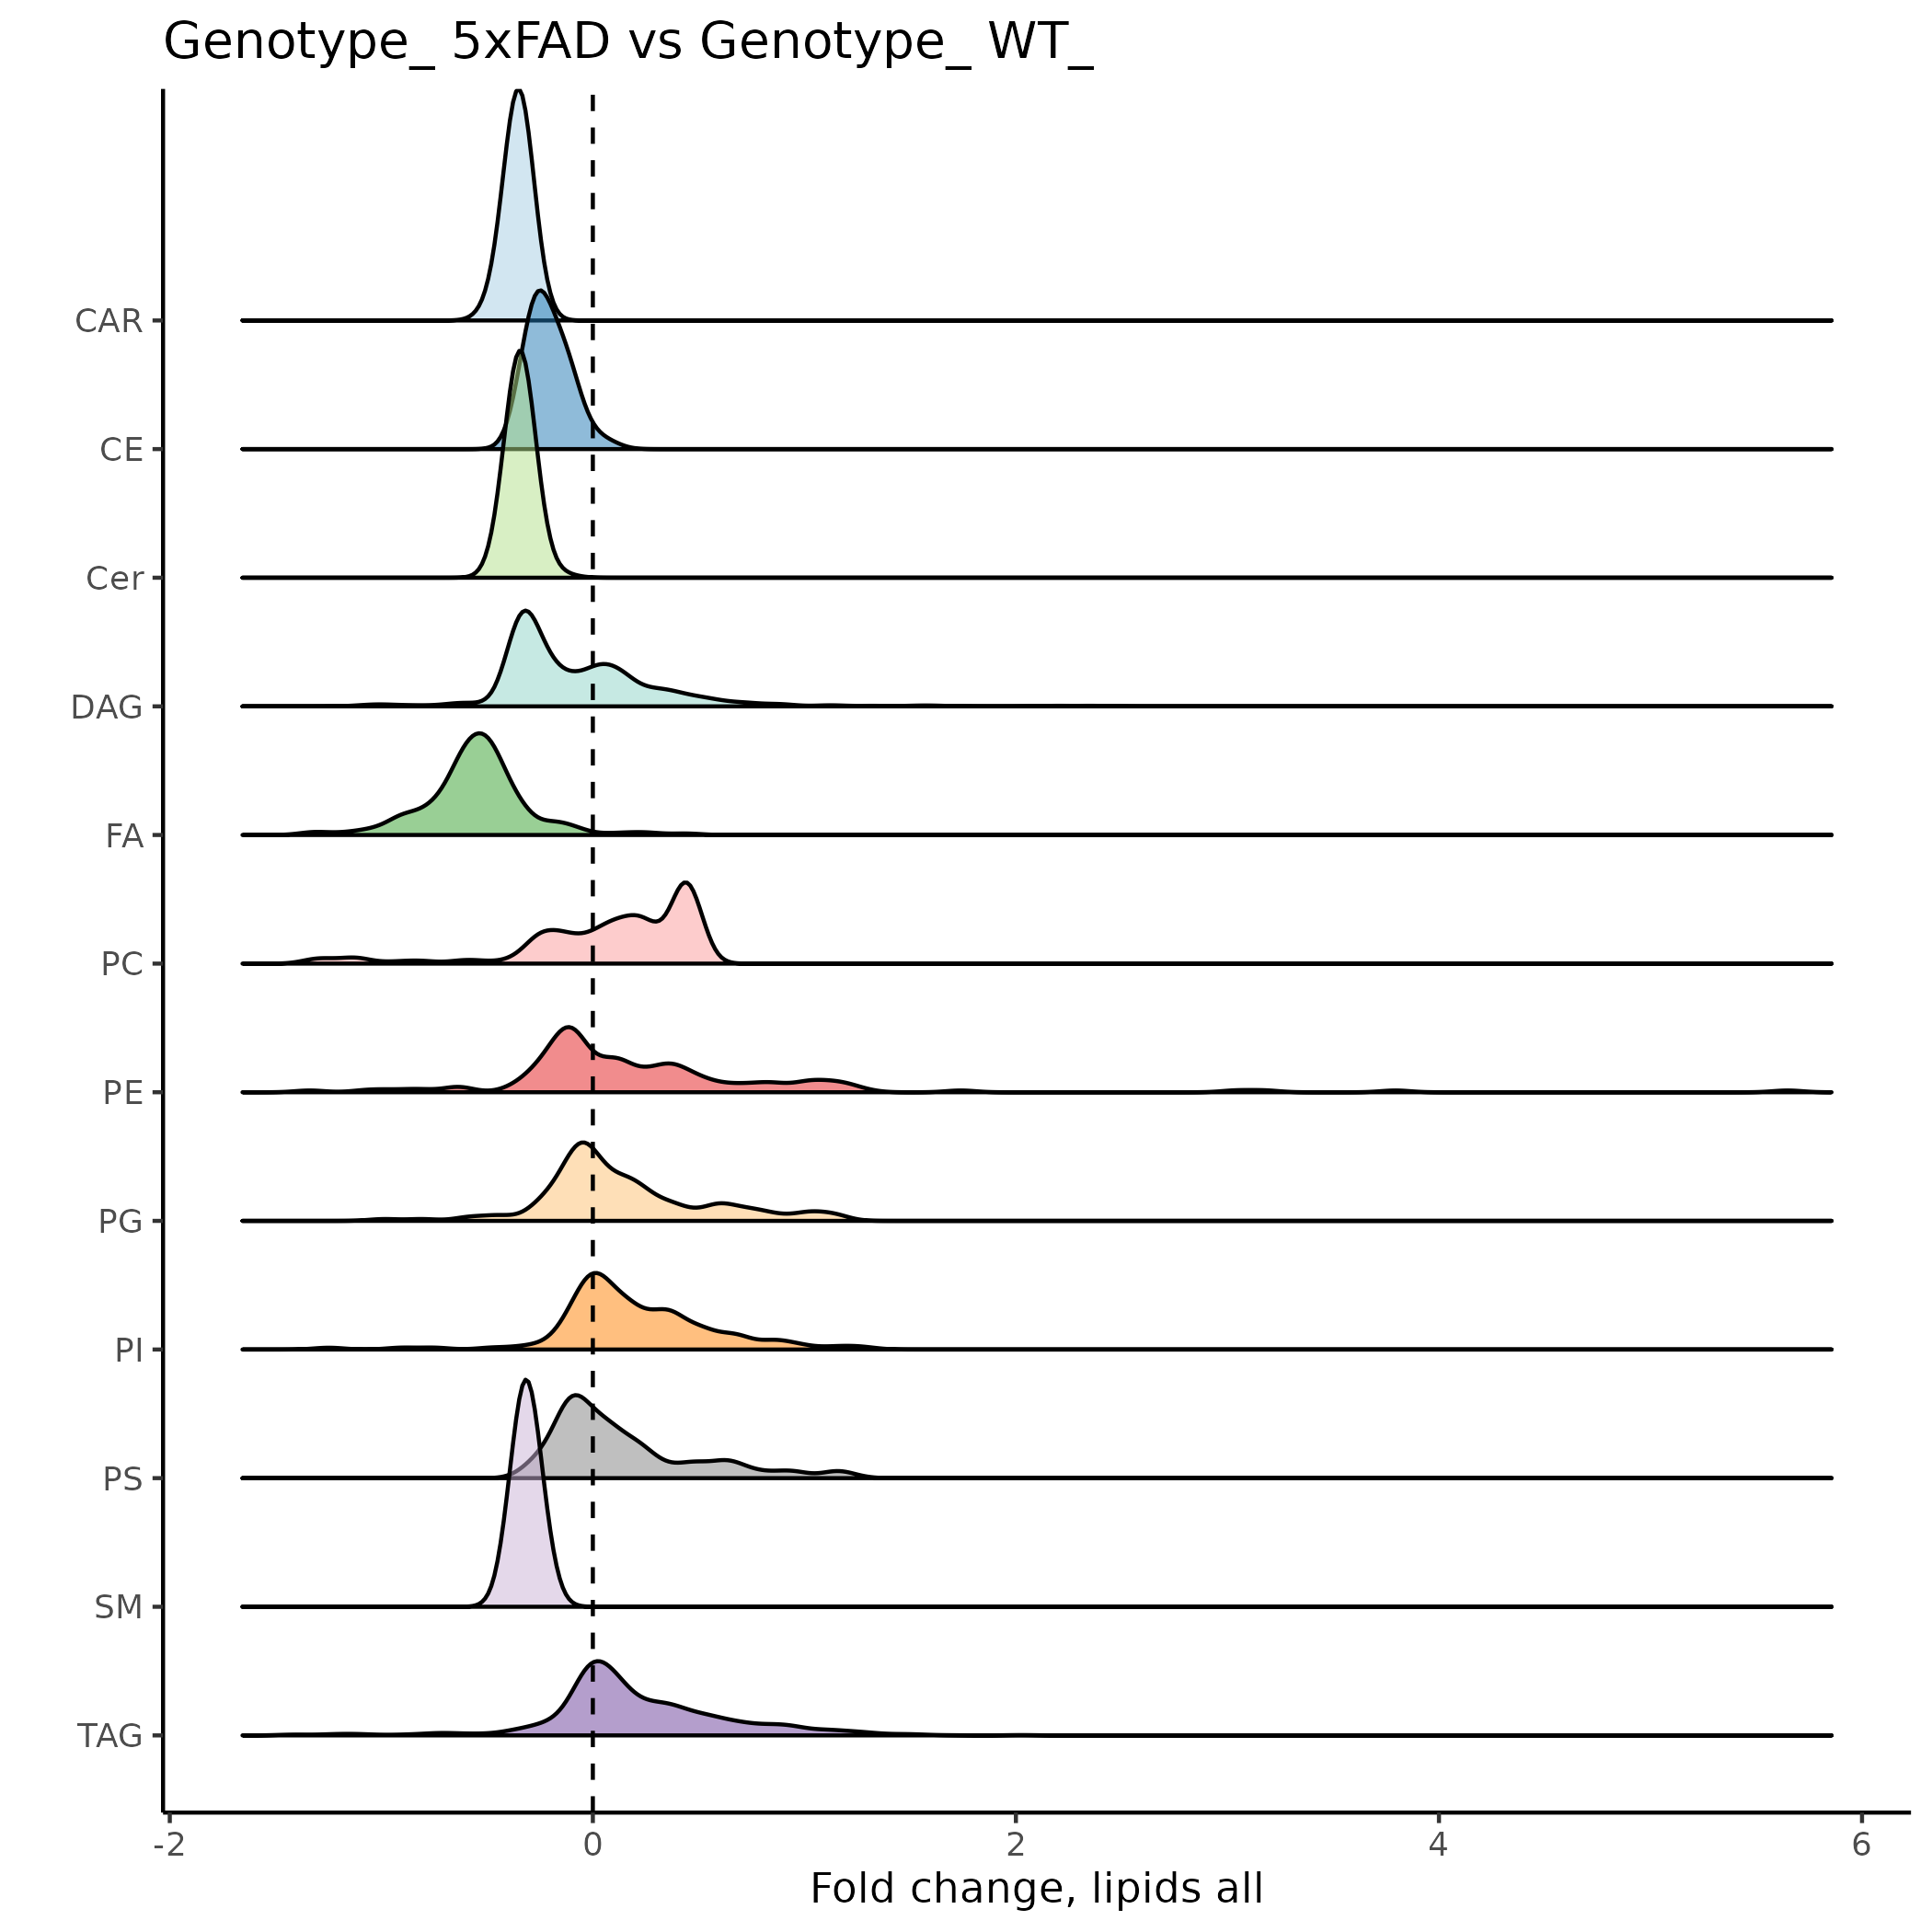

In [13]:
gif = Image(filename=save_name_pie1) # replace 'your_gif.gif' with the path to your GIF
display(gif)
gif = Image(filename=save_name_pie2) # replace 'your_gif.gif' with the path to your GIF
display(gif)
gif = Image(filename=save_name_bar) # replace 'your_gif.gif' with the path to your GIF
display(gif)
gif = Image(filename=title_for_ridge) # replace 'your_gif.gif' with the path to your GIF
display(gif)